In [1]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import LSTM,GRU,Conv1D,GlobalMaxPooling1D,MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
import pandas as pd
train = pd.read_csv('D:/train.csv',header = None)
test = pd.read_csv('D:/test.csv',header = None)
import numpy as np
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Data processing

In [2]:
X_train= train.iloc[1:len(train),2].astype(str).str.lower()
Y_train = train.iloc[1:len(train),3]

In [3]:
X_test= test.iloc[1:len(train),1].astype(str).str.lower()
Y_test = test.iloc[1:len(train),2]

In [4]:
Y_train.value_counts()

neutral     11118
positive     8582
negative     7786
Name: 3, dtype: int64

In [ ]:
Y_test.value_counts()

In [5]:
import string

In [6]:
X_train = X_train.str.replace('[^\w\s]','')

In [7]:
X_test = X_test.str.replace('[^\w\s]','')

In [8]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def convert(text):
    lemmatized_text = []
    for i in text.split():
        lemmatized_text.append(str(wordnet_lemmatizer.lemmatize(i,pos="v")))

    return ' '.join(lemmatized_text)

X_train = X_train.apply(lambda x: convert(x))
X_test = X_test.apply(lambda x: convert(x))

In [9]:
glove = 'D:/glove.840B.300d/glove.840B.300d.txt'
# crawl =  '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'
    
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    if file == '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec':
        embeddings_index = gensim.models.KeyedVectors.load_word2vec_format(crawl)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
    return embeddings_index

In [10]:
embed_glove = load_embed(glove)

In [11]:
len(embed_glove)

2196016

In [12]:
text = X_train.append(X_test)

In [13]:
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(text)
sequences=tokenizer_obj.texts_to_sequences(X_train)

In [14]:
word_index=tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

Found 20158 unique tokens.


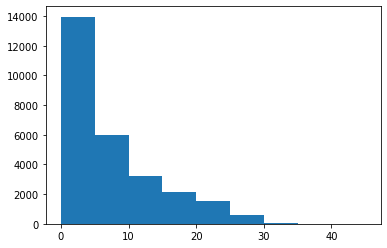

In [51]:
totalNumWords = [len(one_comment) for one_comment in sequences]
plt.hist(totalNumWords,bins = np.arange(0,50,5))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

In [15]:
sentences_pad= pad_sequences(sequences, maxlen=30)
label=Y_train.values
print('Shape of sentences tensor:',sentences_pad.shape)
print('Shape of sentiment tensor:',label.shape)

Shape of sentences tensor: (27486, 30)
Shape of sentiment tensor: (27486,)


In [16]:
EMBEDDING_DIM=300
num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embed_glove.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [17]:
print(num_words)

20159


In [19]:
word_index.items()

array(dict_items([('i', 1), ('be', 2), ('to', 3), ('the', 4), ('a', 5), ('my', 6), ('you', 7), ('and', 8), ('have', 9), ('it', 10), ('in', 11), ('for', 12), ('im', 13), ('of', 14), ('get', 15), ('me', 16), ('go', 17), ('on', 18), ('so', 19), ('that', 20), ('but', 21), ('do', 22), ('not', 23), ('good', 24), ('just', 25), ('its', 26), ('with', 27), ('day', 28), ('love', 29), ('at', 30), ('like', 31), ('work', 32), ('this', 33), ('all', 34), ('no', 35), ('up', 36), ('happy', 37), ('out', 38), ('now', 39), ('miss', 40), ('dont', 41), ('thank', 42), ('too', 43), ('cant', 44), ('time', 45), ('your', 46), ('think', 47), ('want', 48), ('today', 49), ('know', 50), ('see', 51), ('make', 52), ('feel', 53), ('one', 54), ('u', 55), ('lol', 56), ('really', 57), ('what', 58), ('will', 59), ('from', 60), ('back', 61), ('can', 62), ('we', 63), ('great', 64), ('well', 65), ('if', 66), ('about', 67), ('some', 68), ('fun', 69), ('look', 70), ('there', 71), ('sad', 72), ('home', 73), ('as', 74), ('need', 7

# CNN

In [47]:
from keras import layers
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(num_words,
                           EMBEDDING_DIM,
                           input_length=20,
                           embeddings_initializer=Constant(embedding_matrix),
                           trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.Dense(3, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

NameError: name 'Conv1D' is not defined

In [17]:
embedding_matrix.shape

(17410, 300)

# RNN

In [29]:
from keras.initializers import Constant
from keras import regularizers
model = Sequential() 
model.add(Embedding(num_words,
                    EMBEDDING_DIM, 
                    input_length=30,
                    weights=[embedding_matrix],
                    trainable=False)) 
model.add(LSTM(128,activity_regularizer=regularizers.l2(0.01),
               return_sequences=True))
model.add(Dropout(0.6))
model.add(LSTM(128,
                activity_regularizer=regularizers.l2(0.01),
               return_sequences=False))
model.add(Dropout(0.6)) 
model.add(Dense(3, activation='softmax')) 
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) 
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 300)           6047700   
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 128)           219648    
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 387       
Total params: 6,399,319
Trainable params: 351,619
Non-trainable params: 6,047,700
______________________________________

# Modelling

In [19]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

c:\users\sylvain\.conda\envs\test\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [20]:
Y_train=pd.get_dummies(Y_train).values
X_test = tokenizer_obj.texts_to_sequences(X_test)
sentences_pad2= pad_sequences(X_test, maxlen=30)
label2=pd.get_dummies(Y_test).values

In [30]:
history=model.fit(sentences_pad, Y_train, epochs = 20, batch_size = 24, validation_data=(sentences_pad2,label2))

Train on 27486 samples, validate on 3535 samples
Epoch 1/20
27486/27486 [==============================] - 55s 2ms/step - loss: 0.7733 - accuracy: 0.7704 - val_loss: 1.2424 - val_accuracy: 0.5004
Epoch 2/20
27486/27486 [==============================] - 54s 2ms/step - loss: 0.5445 - accuracy: 0.8316 - val_loss: 1.3172 - val_accuracy: 0.5024
Epoch 3/20
27486/27486 [==============================] - 54s 2ms/step - loss: 0.4974 - accuracy: 0.8421 - val_loss: 1.0433 - val_accuracy: 0.5562
Epoch 4/20
27486/27486 [==============================] - 54s 2ms/step - loss: 0.4649 - accuracy: 0.8529 - val_loss: 1.0778 - val_accuracy: 0.5805
Epoch 5/20
27486/27486 [==============================] - 54s 2ms/step - loss: 0.4453 - accuracy: 0.8567 - val_loss: 1.0507 - val_accuracy: 0.5827
Epoch 6/20
27486/27486 [==============================] - 54s 2ms/step - loss: 0.4246 - accuracy: 0.8649 - val_loss: 1.2347 - val_accuracy: 0.5465
Epoch 7/20
27486/27486 [==============================] - 54s 2ms/ste

In [70]:
mcp_save.params

{'batch_size': 8,
 'epochs': 20,
 'steps': None,
 'samples': 27486,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

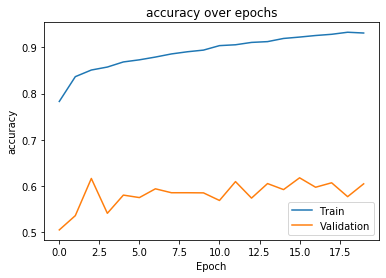

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy over epochs')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [25]:
Y_test.value_counts()

neutral     1430
positive    1104
negative    1001
Name: 2, dtype: int64

In [27]:
loss, acc = model.evaluate(sentences_pad2, label2)
print("Test loss = ",loss)
print("Test accuracy = ", acc)

3535/3535 [==============================] - 1s 345us/step
Test loss =  1.6674513600334588
Test accuracy =  0.604809045791626
